Card
    [0] Column
        [0] Row
            [0] Column
                [0] Bokeh(Figure)
            [1] Column
                [0] TextInput(placeholder='Paste veo link', width=200)
                [1] Row
                    [0] TextInput(placeholder='Home team', width=90)
                    [1] TextInput(placeholder='Away team', width=90)
                [2] TextInput(placeholder='Highlight (in mm:ss)', width=200)
                [3] RadioBoxGroup(inline=True, name='Home team attacking d..., options=['Left to Right', ...], value='Left to Right')
                [4] RadioButtonGroup(name='Team Group', options=['Home', 'Away'], value='Home', width=200)
                [5] Markdown(str)
                [6] TextInput(value='0', width=200)
                [7] RadioButtonGroup(name='Game Situation', options=['Open play', ...], orientation='vertical', width=200)
                [8] RadioButtonGroup(name='Shot Type', options=['Foot', 'Head'], value='Foot', width=200)
                [9] RadioButtonGroup(name='Outcome Type', options=['Goal', 'No Goal', ...], value='No Goal', width=200)
                [10] RadioButtonGroup(name='Shot Placement Type', options=['Off Target', ...], value='Off Target', width=200)
                [11] Button(button_type='success', name='Add possession', width=200)
            [2] Row
                [0] Column
                    [0] Bokeh(DataTable)
                    [1] Bokeh(DataTable)
    [1] Row
        [0] Bokeh(DataTable, width=800)
        [1] Column
            [0] Button(button_type='danger', name='Clear data', width=200)
            [1] FileDownload(button_type='success', callback=<function download_data a..., filename='tagger_data__.csv', label='Download data', margin=(10, 12, 10, 10), width=200)
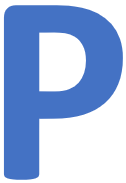
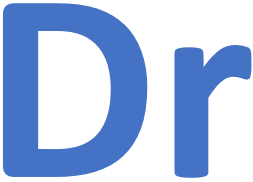
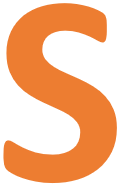
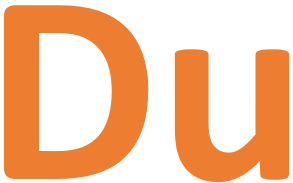
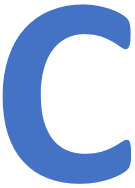

In [2]:
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50

import warnings
warnings.filterwarnings("ignore")

# common stats imports
from math import pi

from bokeh.plotting import figure
from bokeh.models import DataTable, TableColumn, PointDrawTool, PolyDrawTool, ColumnDataSource, Range1d, NumberFormatter
from bokeh.io import output_notebook
import panel as pn

from io import StringIO
from pathlib import Path


def draw_pitch(width=700, height=500, fill_color='#FFFFFF', fill_alpha=0.5, hpad=0.25, vpad=0.25,
               line_color='grey', goalline_color='#969696', line_alpha=1, hspan=[0, 100], vspan=[0, 100], arcs=True):
    '''
    -----
    Draws and returns a pitch on a Bokeh figure object with width 105m and height 68m
    p = drawpitch()

    '''

    # measures:
    # goalcenter to post, fiveyard-box-length, fiveyard-width,
    # box-width, penalty-spot x-distance, circle-radius

    measures = [4.8, 5.8, 13.2, 17, 57.8, 11.5, 8.71]
    hspan = [0, 100]
    vspan = [0, 100]

    hmid = (hspan[1]+hspan[0])/2
    vmid = (vspan[1]+vspan[0])/2

    p = figure(width=width,
               height=height,
               x_range=Range1d(hspan[0]-hpad, hspan[1]+hpad),
               y_range=Range1d(vspan[0]-vpad, vspan[1]+vpad),
               tools=[])

    boxes = p.quad(top=[vspan[1], vmid+measures[2], vmid+measures[4]/2, vmid+measures[4]/2, vmid+measures[2]],
                   bottom=[vspan[0], vmid-measures[2], vmid-measures[4]/2, vmid-measures[4]/2, vmid-measures[2]],
                   left=[hspan[0], hspan[1]-measures[1], hspan[1]-measures[3], hspan[0]+measures[3], hspan[0]+measures[1]],
                   right=[hspan[1], hspan[1], hspan[1], hspan[0], hspan[0]],
                   color=fill_color,
                   alpha=[fill_alpha, 0, 0, 0, 0],
                   line_width=2,
                   line_alpha=line_alpha,
                   line_color=line_color)
    boxes.selection_glyph = boxes.glyph
    boxes.nonselection_glyph = boxes.glyph

    # middle circle
    p.circle(x=[hmid], y=[vmid], radius=measures[6], color=line_color, line_width=2, fill_alpha=0, fill_color='grey', line_color=line_color)

    if arcs is True:
        p.arc(x=[hspan[0]+measures[5], hspan[1]-measures[5]], y=[vmid, vmid],
              radius=measures[6],
              start_angle=[(2*pi-np.arccos((measures[3]-measures[5])/measures[6])), pi - np.arccos((measures[3]-measures[5])/measures[6])],
              end_angle=[np.arccos((measures[3]-measures[5])/measures[6]), pi + np.arccos((measures[3]-measures[5])/measures[6])],
              color=line_color,
              line_width=2)

    p.circle([hmid, hspan[1]-measures[5], hspan[0]+measures[5]], [vmid, vmid, vmid], size=5, color=line_color, alpha=1)
    # midfield line
    p.line([hmid, hmid], [vspan[0], vspan[1]], line_width=2, color=line_color)
    # goal lines
    p.line((hspan[1], hspan[1]), (vmid+measures[0], vmid-measures[0]), line_width=6, color=goalline_color)
    p.line((hspan[0], hspan[0]), (vmid+measures[0], vmid-measures[0]), line_width=6, color=goalline_color)

    p.grid.visible = False
    p.xaxis.visible = False
    p.yaxis.visible = False

    return p

pn.extension()

pitch_width = 105*8
pitch_height = 68*8

p = draw_pitch(width=pitch_width, height=pitch_height)

pink = '#e0218a'
blue = '#42c0fb'

##drawing tool sources

sourceShot = ColumnDataSource({'x': [], 'y': [], 'action': []})
sourceLines = ColumnDataSource(data=dict(
      xs=[],
      ys=[],
    action=[]
))



##drawing tool renderes
rendererShot = p.circle(x='x', y='y',
                    source=sourceShot,
                    color='#ff6600',
                    size=10)

rendererDuel = p.circle(x='x', y='y',
                    source=sourceShot,
                    color='#ff6600',
                    size=10)

rendererPass = p.multi_line(xs='xs', ys='ys',
                    source=sourceLines,
                    color='#42c0fb',
                    line_width=5,
                    line_alpha=0.4)

rendererCross = p.multi_line(xs='xs', ys='ys',
                    source=sourceLines,
                    color='#42c0fb',
                    line_width=5,
                    line_alpha=0.4)

rendererCarry = p.multi_line(xs='xs', ys='ys',
                    source=sourceLines,
                    color='#42c0fb',
                    line_width=5,
                    line_alpha=0.4)




formatter = NumberFormatter(format='0.00')

## dot when it's a single point action, eg. shot, tackle, duel -- line when an action has a end point different to the starting point

columnsDot = [TableColumn(field="x", title="x", formatter=formatter),
           TableColumn(field="y", title="y", formatter=formatter),
           TableColumn(field='action', title='action')]

columnsLine = [TableColumn(field="xs", title="xs"),
           TableColumn(field="ys", title="ys"),
           TableColumn(field='action', title='action')]


tableShot = DataTable(source=sourceShot, columns=columnsDot, editable=True, height=150, width=210)
tablePass = DataTable(source=sourceLines, columns=columnsLine, editable=True, height=150, width=210)

draw_toolPass = PolyDrawTool(renderers=[rendererPass], empty_value='pass', custom_icon=Path('img\pass.png'))
draw_toolCarry = PolyDrawTool(renderers=[rendererPass], empty_value='dribble', custom_icon=Path('img\dribble.png'))
draw_toolCross = PolyDrawTool(renderers=[rendererPass], empty_value='cross', custom_icon=Path('img\cross.png'))
draw_toolShot = PointDrawTool(renderers=[rendererShot], empty_value='shot', custom_icon=Path('img\shot.png'))
draw_toolDuel = PointDrawTool(renderers=[rendererShot], empty_value='duel', custom_icon=Path('img\duel.png'))

p.add_tools(draw_toolPass)
p.add_tools(draw_toolCarry)
p.add_tools(draw_toolCross)
p.add_tools(draw_toolShot)
p.add_tools(draw_toolDuel)

p.toolbar.active_tap = draw_toolPass

outputCols = ['action','xStart','xEnd','yStart','yEnd','team','possessionNo','indexInPossession','highlightStart','shotOutcome','shotBodyPart','shotPlacement', 'homeTeam', 'awayTeam', "gameSituation", "url"]
outputColsTable = [TableColumn(field=col, title=col) for col in outputCols]

sourceOutput = ColumnDataSource({col: [] for col in outputCols})

tableOutput = DataTable(source=sourceOutput,
                     columns=outputColsTable,
                     editable=True, height=100, width=200)

## set buttons

highlight_start = pn.widgets.TextInput(placeholder='Highlight (in mm:ss)', width=200)
url = pn.widgets.TextInput(placeholder='Paste veo link', width=200)

home_team_name = pn.widgets.TextInput(placeholder='Home team', width=90)
away_team_name = pn.widgets.TextInput(placeholder='Away team', width=90)


possession_text = pn.widgets.TextInput(value='0', width=200)
possession_count = pn.widgets.Button(name='Add possession number', button_type='primary', width=200)
reset_possession_count = pn.widgets.Button(name='Reset possession number', button_type='default', width=200)

att_direction = pn.widgets.RadioBoxGroup(name='Home team attacking direction', options=['Left to Right', 'Right to Left'], inline=True)

team_group = pn.widgets.RadioButtonGroup(
    name='Team Group', value='Home', options=['Home', 'Away'], button_type='default', width=200)

shot_type = pn.widgets.RadioButtonGroup(
    name='Shot Type', value='Foot', options=['Foot', 'Head'], button_type='default', width=200)

shot_placement_type = pn.widgets.RadioButtonGroup(
    name='Shot Placement Type', value='Off Target', options=['Off Target', 'On Target', 'Blocked'], button_type='default', width=200)

game_situation = pn.widgets.RadioButtonGroup(
    name='Game Situation', value='Open Play', options=['Open play', 'Free kick' ,'Corner', 'Throw-in', 'Penalty'], button_type='default', orientation='vertical', width=200)

outcome_type = pn.widgets.RadioButtonGroup(
    name='Outcome Type', value='No Goal', options=['Goal', 'No Goal', 'Own Goal'], button_type='default', width=200)

## set button functions

def possession_counter(event):
    possession_text.value = f'{possession_count.clicks}'
    
def reset_possession_counter(event):
    possession_text.value = '1'

## set button behaviour

possession_count.on_click(possession_counter)
reset_possession_count.on_click(reset_possession_counter)


## data processing

def dataProcessing(event):
    df_pass = pd.DataFrame(sourceLines.data)
    
    df_pass["lenXs"] = df_pass['xs'].apply(lambda x: len(x))
    df_pass["lenYs"] = df_pass['ys'].apply(lambda x: len(x))
    df_pass = df_pass[(df_pass['lenXs']==2) & (df_pass['lenYs']==2)]
    df_pass.drop(['lenXs','lenYs'], axis=1, inplace=True)
    
    for idx, row in df_pass.iterrows():
        df_pass.at[idx, 'xStart'] = round(row['xs'][0], 2)
        df_pass.at[idx, 'xEnd'] = round(row['xs'][1], 2)
        df_pass.at[idx, 'yStart'] = round(row['ys'][0], 2)
        df_pass.at[idx, 'yEnd'] = round(row['ys'][1], 2)
    df_pass.drop(['xs', 'ys'], axis=1, inplace=True)

    df_shot = pd.DataFrame(sourceShot.data)
    for idx, row in df_shot.iterrows():
        df_shot.at[idx, 'xStart'] = round(row['x'], 2)
        df_shot.at[idx, 'xEnd'] = round(row['x'], 2)
        df_shot.at[idx, 'yStart'] = round(row['y'], 2)
        df_shot.at[idx, 'yEnd'] = round(row['y'], 2)

    df_shot.drop(['x','y'], axis=1, inplace=True)

    df = df_pass.append(df_shot, ignore_index=True)

    df['team'] = team_group.value
    df['possessionNo'] = possession_text.value
    df["indexInPossession"] = df.index.astype('int64')
    df["highlightStart"] = highlight_start.value
    df["shotOutcome"] = outcome_type.value
    df["shotBodyPart"] = shot_type.value
    df["shotPlacement"] = shot_placement_type.value
    df["homeTeam"] = home_team_name.value
    df["awayTeam"] = away_team_name.value
    df["gameSituation"] = game_situation.value
    df["url"] = url.value
    
    if att_direction.value.lower() == "right to left":
        df['xStart'] = round(100 - df['xStart'], 2)
        df['xEnd'] = round(100 - df['xEnd'], 2)
        df['yStart'] = round(100 - df['yStart'], 2)
        df['yEnd'] = round(100 - df['yEnd'], 2)

    outputData = df.reset_index(drop=True)
    sourceOutput.stream(outputData.to_dict('list'))
    sourceShot.data = {'x': [], 'y': [], 'action': []}
    sourceLines.data = {'xs': [], 'ys': [], 'action': []}
    
    possession_text.value = str(int(possession_text.value)+1)
    highlight_start.value = ''
    
    p.toolbar.active_tap = draw_toolPass

add_possession = pn.widgets.Button(name='Add possession', width=200, button_type='success')
add_possession.on_click(dataProcessing)

def download_data():
    df_output = pd.DataFrame(sourceOutput.data)
    if len(df_output) > 0:
        df_output = df_output.reset_index(drop=True)
        sio = StringIO()
        df_output.to_csv(sio)
        sio.seek(0)
        return sio
    
def clear_data(event):
    sourceOutput.data = {col: [] for col in outputCols}
    possession_text.value = '0'
    
clear_btn = pn.widgets.Button(name='Clear data', width=200, button_type='danger')
clear_btn.on_click(clear_data)

filename = f'tagger_data_{home_team_name.value}_{away_team_name.value}.csv'

dl_button = pn.widgets.FileDownload(callback=download_data, filename=f'tagger_data_{home_team_name.value}_{away_team_name.value}.csv',
                                    button_type='success', width=200, margin=(10, 12, 10, 10), label='Download data')



# layout

layout = pn.Card(pn.Column(pn.Row(pn.Column(pn.pane.Bokeh(p)),
                        pn.Column(url, pn.Row(home_team_name, away_team_name), highlight_start, att_direction, team_group, 'Current possession',possession_text,\
                                  game_situation, shot_type, outcome_type, shot_placement_type, add_possession),
                        pn.Row(pn.Column(pn.pane.Bokeh(tableShot), pn.pane.Bokeh(tablePass))))),pn.Row(pn.pane.Bokeh(tableOutput, width=pitch_width-40), pn.Column(clear_btn, dl_button)))


layout.servable()
